In [25]:
# This notebook will be for clustering modeling (Unsupervised Learning)
# Mini Kmeans, maybe DBSCAN(Density-Based Spatial Clustering of Applications with Noise)(GOWER) to detect noise
# Importing the libraries

# Can be useful in segmentation and stratification. Annomalies can be detected using clustering algorithms, e.g. fraud detection
# Could find some hidden patterns in the data, from there can go back to classification and add more features to the model
# Preprocessing: scaling, encoding, flag missingness (not same as imputation), outlier detection

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools import add_constant
from sklearn.decomposition import PCA
from umap import UMAP

In [26]:
# importing data

from dotenv import load_dotenv

load_dotenv()

dataset_path = os.getenv('CLEANED_DATA_PATH')

df_cleaned = pd.read_csv(dataset_path)

In [27]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307507 entries, 0 to 307506
Data columns (total 51 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   SK_ID_CURR                   307507 non-null  int64  
 1   TARGET                       307507 non-null  int64  
 2   NAME_CONTRACT_TYPE           307507 non-null  object 
 3   CODE_GENDER                  307507 non-null  object 
 4   FLAG_OWN_CAR                 307507 non-null  object 
 5   FLAG_OWN_REALTY              307507 non-null  object 
 6   CNT_CHILDREN                 307507 non-null  int64  
 7   AMT_INCOME_TOTAL             307507 non-null  float64
 8   AMT_CREDIT                   307507 non-null  float64
 9   AMT_ANNUITY                  307495 non-null  float64
 10  NAME_TYPE_SUITE              306215 non-null  object 
 11  NAME_INCOME_TYPE             307507 non-null  object 
 12  NAME_EDUCATION_TYPE          307507 non-null  object 
 13 

# PREPROCESSING - SPLIT, IMPUTE, ENCODE, SCALE

### SPLIT

In [28]:
# removing ID column from the dataframe
df_cleaned = df_cleaned.drop(['SK_ID_CURR'], axis=1)

# remove the target varliable from dataframe
df_cleaned = df_cleaned.drop(['TARGET'], axis=1)

In [29]:
# splitting the data into categorical and numerical columns
# creating list of categorical columns 
categorical_cols = df_cleaned.select_dtypes(include=['object']).columns.tolist()
categorical_cols

# creating list of numerical columns
numerical_cols = df_cleaned.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_cols

['CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT_W_CITY',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'DAYS_LAST_PHONE_CHANGE',
 'FLAG_DOCUMENT_3',
 'AMT_REQ_CREDIT_BUREAU_HOUR',
 'AMT_REQ_CREDIT_BUREAU_DAY',
 'AMT_REQ_CREDIT_BUREAU_WEEK',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'AMT_REQ_CREDIT_BUREAU_YEAR',
 'AGE',
 'YEARS_EMPLOYED']

#### For Numerical Columns Only

In [30]:
# confirming the number of categorical and numerical columns
df_cleaned.info()

print(len(categorical_cols))
print(len(numerical_cols))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307507 entries, 0 to 307506
Data columns (total 49 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   NAME_CONTRACT_TYPE           307507 non-null  object 
 1   CODE_GENDER                  307507 non-null  object 
 2   FLAG_OWN_CAR                 307507 non-null  object 
 3   FLAG_OWN_REALTY              307507 non-null  object 
 4   CNT_CHILDREN                 307507 non-null  int64  
 5   AMT_INCOME_TOTAL             307507 non-null  float64
 6   AMT_CREDIT                   307507 non-null  float64
 7   AMT_ANNUITY                  307495 non-null  float64
 8   NAME_TYPE_SUITE              306215 non-null  object 
 9   NAME_INCOME_TYPE             307507 non-null  object 
 10  NAME_EDUCATION_TYPE          307507 non-null  object 
 11  NAME_FAMILY_STATUS           307507 non-null  object 
 12  NAME_HOUSING_TYPE            307507 non-null  object 
 13 

In [31]:
# numerical dataframe
df_num = df_cleaned[numerical_cols]

# categorical dataframe
df_cat = df_cleaned[categorical_cols]

### IMPUTE

In [32]:
# scaling the numerical columns using RobustScaler
# scaler = RobustScaler()
# df_num[numerical_cols] = scaler.fit_transform(df_num[numerical_cols])

In [33]:
# imputing missing values for numerical columns
imputer = ColumnTransformer(transformers=
                        [('num_imp', SimpleImputer(strategy='median', add_indicator=False), numerical_cols),
                        ('cat_imp', SimpleImputer(strategy='most_frequent', add_indicator=False), categorical_cols)], 
                        remainder="passthrough").set_output(transform='pandas')
df_cleaned = imputer.fit_transform(df_cleaned)

In [34]:
df_cleaned

,num_imp__CNT_CHILDREN,num_imp__AMT_INCOME_TOTAL,num_imp__AMT_CREDIT,num_imp__AMT_ANNUITY,num_imp__REGION_POPULATION_RELATIVE,num_imp__DAYS_BIRTH,num_imp__DAYS_EMPLOYED,num_imp__DAYS_REGISTRATION,num_imp__DAYS_ID_PUBLISH,num_imp__FLAG_EMP_PHONE,...,cat_imp__NAME_EDUCATION_TYPE,cat_imp__NAME_FAMILY_STATUS,cat_imp__NAME_HOUSING_TYPE,cat_imp__OCCUPATION_TYPE,cat_imp__WEEKDAY_APPR_PROCESS_START,cat_imp__ORGANIZATION_TYPE,cat_imp__AMT_INCOME_RANGE,cat_imp__AMT_CREDIT_RANGE,cat_imp__AGE_GROUP,cat_imp__EMPLOYMENT_YEAR
0,0.0,2.025,4.065975,24700.5,0.018801,9461.0,637.0,3648.0,2120.0,1.0,...,Secondary / secondary special,Single / not married,House / apartment,Laborers,WEDNESDAY,Business Entity Type 3,200k-300k,400k-500k,20-30,0-5
1,0.0,2.700,12.935025,35698.5,0.003541,16765.0,1188.0,1186.0,291.0,1.0,...,Higher education,Married,House / apartment,Core staff,MONDAY,School,200k-300k,1M Above,40-50,0-5
2,0.0,0.675,1.350000,6750.0,0.010032,19046.0,225.0,4260.0,2531.0,1.0,...,Secondary / secondary special,Single / not married,House / apartment,Laborers,MONDAY,Government,0-100K,100K-200K,50 above,0-5
3,0.0,1.350,3.126825,29686.5,0.008019,19005.0,3039.0,9833.0,2437.0,1.0,...,Secondary / secondary special,Civil marriage,House / apartment,Laborers,WEDNESDAY,Business Entity Type 3,100K-200K,300k-400k,50 above,5-10
4,0.0,1.215,5.130000,21865.5,0.028663,19932.0,3038.0,4311.0,3458.0,1.0,...,Secondary / secondary special,Single / not married,House / apartment,Core staff,THURSDAY,Religion,100K-200K,500k-600k,50 above,5-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307502,0.0,1.575,2.547000,27558.0,0.032561,9327.0,236.0,8456.0,1982.0,1.0,...,Secondary / secondary special,Separated,With parents,Sales staff,THURSDAY,Services,100K-200K,200k-300k,20-30,0-5
307503,0.0,0.720,2.695500,12001.5,0.025164,20775.0,365243.0,4388.0,4090.0,0.0,...,Secondary / secondary special,Widow,House / apartment,Retiree,MONDAY,XNA,0-100K,200k-300k,50 above,Unknown
307504,0.0,1.530,6.776640,29979.0,0.005002,14966.0,7921.0,6737.0,5150.0,1.0,...,Higher education,Separated,House / apartment,Managers,THURSDAY,School,100K-200K,600k-700k,40-50,20-30
307505,0.0,1.710,3.701070,20205.0,0.005313,11961.0,4786.0,2562.0,931.0,1.0,...,Secondary / secondary special,Married,House / apartment,Laborers,WEDNESDAY,Business Entity Type 1,100K-200K,300k-400k,30-40,10-20


### ENCODE

In [35]:
categorical_cols_imp = df_cleaned.select_dtypes(include=['object']).columns.tolist()

# finding cat columns that are binary
binary_cat_col_imp = []
for col in categorical_cols_imp:
    if df_cleaned[col].nunique() == 2:
        binary_cat_col_imp.append(col)

# removing binary columns from list before OHE
for col in binary_cat_col_imp:
    categorical_cols_imp.remove(col)
        

# label encoding binary categorical variables, converting to 0 or 1
le = LabelEncoder()
for col in binary_cat_col_imp:
    df_cleaned[col] = le.fit_transform(df_cleaned[col])

# onehot encoding multiclass category variables
ct = ColumnTransformer(transformers=[('ohe', OneHotEncoder(sparse_output=False), categorical_cols_imp)], 
                    remainder="passthrough").set_output(transform='pandas')

df_cleaned = ct.fit_transform(df_cleaned)

df_cleaned

,ohe__cat_imp__NAME_TYPE_SUITE_Children,ohe__cat_imp__NAME_TYPE_SUITE_Family,ohe__cat_imp__NAME_TYPE_SUITE_Group of people,ohe__cat_imp__NAME_TYPE_SUITE_Other_A,ohe__cat_imp__NAME_TYPE_SUITE_Other_B,"ohe__cat_imp__NAME_TYPE_SUITE_Spouse, partner",ohe__cat_imp__NAME_TYPE_SUITE_Unaccompanied,ohe__cat_imp__NAME_INCOME_TYPE_Businessman,ohe__cat_imp__NAME_INCOME_TYPE_Commercial associate,ohe__cat_imp__NAME_INCOME_TYPE_Maternity leave,...,remainder__num_imp__AMT_REQ_CREDIT_BUREAU_WEEK,remainder__num_imp__AMT_REQ_CREDIT_BUREAU_MON,remainder__num_imp__AMT_REQ_CREDIT_BUREAU_QRT,remainder__num_imp__AMT_REQ_CREDIT_BUREAU_YEAR,remainder__num_imp__AGE,remainder__num_imp__YEARS_EMPLOYED,remainder__cat_imp__NAME_CONTRACT_TYPE,remainder__cat_imp__CODE_GENDER,remainder__cat_imp__FLAG_OWN_CAR,remainder__cat_imp__FLAG_OWN_REALTY
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,25.0,1.745205,0,1,0,1
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,45.0,3.254795,0,0,0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,52.0,0.616438,1,1,1,1
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,52.0,8.326027,0,0,0,1
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,54.0,8.323288,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307502,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,25.0,0.646575,0,1,0,0
307503,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,56.0,1000.665753,0,0,0,1
307504,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,41.0,21.701370,0,0,0,1
307505,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,32.0,13.112329,0,0,0,1


### SCALE

In [39]:
# This is wrong
scaler = RobustScaler()
scaled_data = scaler.fit_transform(df_cleaned)
df_scaled = pd.DataFrame(scaled_data, columns=df_cleaned.columns)
df_scaled.head()

,ohe__cat_imp__NAME_TYPE_SUITE_Children,ohe__cat_imp__NAME_TYPE_SUITE_Family,ohe__cat_imp__NAME_TYPE_SUITE_Group of people,ohe__cat_imp__NAME_TYPE_SUITE_Other_A,ohe__cat_imp__NAME_TYPE_SUITE_Other_B,"ohe__cat_imp__NAME_TYPE_SUITE_Spouse, partner",ohe__cat_imp__NAME_TYPE_SUITE_Unaccompanied,ohe__cat_imp__NAME_INCOME_TYPE_Businessman,ohe__cat_imp__NAME_INCOME_TYPE_Commercial associate,ohe__cat_imp__NAME_INCOME_TYPE_Maternity leave,...,remainder__num_imp__AMT_REQ_CREDIT_BUREAU_WEEK,remainder__num_imp__AMT_REQ_CREDIT_BUREAU_MON,remainder__num_imp__AMT_REQ_CREDIT_BUREAU_QRT,remainder__num_imp__AMT_REQ_CREDIT_BUREAU_YEAR,remainder__num_imp__AGE,remainder__num_imp__YEARS_EMPLOYED,remainder__cat_imp__NAME_CONTRACT_TYPE,remainder__cat_imp__CODE_GENDER,remainder__cat_imp__FLAG_OWN_CAR,remainder__cat_imp__FLAG_OWN_REALTY
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-0.947368,-0.331378,0.0,1.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-0.5,0.105263,-0.215961,0.0,0.0,0.0,-1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-0.5,0.473684,-0.417679,1.0,1.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.473684,0.171764,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-0.5,0.578947,0.171554,0.0,1.0,0.0,0.0


## Multicollinearity Detection

In [40]:
# Multicollinearity detection
vif = pd.DataFrame()

# point here suspicious variables or just all variables
df_vif = add_constant(df_scaled)
vif["VIF"] = [variance_inflation_factor(df_vif.values, i) for i in range(df_vif.shape[1])]
vif["variables"] = df_vif.columns

print(vif)
# vif 1-5 - ok, there is no strong correlation
# if vif more than 5 - there is strong correlation
# if vif is inf - there is extremely high correlation (linear dependence)

c:\Users\parks\OneDrive\Documents\Loan_project\loan_project\venv\Lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
c:\Users\parks\OneDrive\Documents\Loan_project\loan_project\venv\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


KeyboardInterrupt: 

In [ ]:
# dropping columns that have high collinearity
df_num = df_num.drop(labels=['numimp__FLAG_EMP_PHONE', 'numimp__REG_REGION_NOT_WORK_REGION', 
                    'numimp__REG_CITY_NOT_WORK_CITY', 'numimp__LIVE_CITY_NOT_WORK_CITY'], axis=1)

In [ ]:
df_num

,numimp__CNT_CHILDREN,numimp__AMT_GOODS_PRICE,numimp__REGION_POPULATION_RELATIVE,numimp__DAYS_REGISTRATION,numimp__DAYS_ID_PUBLISH,numimp__FLAG_WORK_PHONE,numimp__CNT_FAM_MEMBERS,numimp__REGION_RATING_CLIENT_W_CITY,numimp__HOUR_APPR_PROCESS_START,numimp__REG_REGION_NOT_LIVE_REGION,...,numimp__EXT_SOURCE_3,numimp__DEF_30_CNT_SOCIAL_CIRCLE,numimp__OBS_60_CNT_SOCIAL_CIRCLE,numimp__DEF_60_CNT_SOCIAL_CIRCLE,numimp__DAYS_LAST_PHONE_CHANGE,numimp__FLAG_DOCUMENT_3,numimp__AMT_REQ_CREDIT_BUREAU_HOUR,numimp__CREDT_INCOME_RATIO,numimp__EMP_AGE_RATIO,numimp__ANNUITY_INCOME_RATIO
0,0.0,-0.224490,-0.002626,-0.156504,-0.439705,0.0,-1.0,0.0,-0.50,0.0,...,-1.326713,2.0,1.0,2.0,0.290895,0.0,0.0,-0.400217,-0.290838,-0.357494
1,0.0,1.540816,-0.820550,-0.606637,-1.148895,0.0,0.0,-1.0,-0.25,0.0,...,0.000000,0.0,0.5,0.0,0.054784,0.0,0.0,0.485694,-0.282515,-0.267902
2,0.0,-0.714286,-0.472638,-0.044611,-0.280341,1.0,-1.0,0.0,-0.75,0.0,...,0.651092,0.0,0.0,0.0,0.044753,-1.0,0.0,-0.402728,-0.482196,-0.549803
3,0.0,-0.346939,-0.580533,0.974312,-0.316789,0.0,0.0,0.0,1.25,0.0,...,0.000000,0.0,1.0,0.0,-0.108025,0.0,0.0,-0.302078,0.007352,0.499344
4,0.0,0.142857,0.525969,-0.035287,0.079100,0.0,-1.0,0.0,-0.25,0.0,...,0.000000,0.0,0.0,0.0,0.269290,-1.0,0.0,0.304706,-0.012397,0.149887
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307502,0.0,-0.510204,0.734898,0.722552,-0.493214,0.0,-1.0,-1.0,0.75,0.0,...,0.000000,0.0,0.0,0.0,-0.373457,-1.0,0.0,-0.524609,-0.435941,0.106211
307503,0.0,-0.510204,0.338425,-0.021209,0.324157,0.0,-1.0,0.0,-1.00,0.0,...,0.000000,0.0,0.0,0.0,-0.584105,0.0,0.0,0.152387,58.480877,0.033725
307504,0.0,0.306122,-0.742242,0.408264,0.735169,0.0,-1.0,1.0,-0.75,0.0,...,-1.060354,0.0,3.0,0.0,0.888889,0.0,1.0,0.370589,1.226376,0.289700
307505,0.0,-0.295918,-0.725572,-0.355060,-0.900737,0.0,0.0,0.0,-0.75,0.0,...,0.421395,0.0,0.0,0.0,-0.335648,0.0,0.0,-0.350402,0.831659,-0.390918


In [ ]:
# Multicollinearity detection
vif = pd.DataFrame()

# point here suspicious variables or just all variables
df_vif = add_constant(df_num)
vif["VIF"] = [variance_inflation_factor(df_vif.values, i) for i in range(df_vif.shape[1])]
vif["variables"] = df_vif.columns

print(vif)

         VIF                            variables
0   4.025164                                const
1   4.547696                 numimp__CNT_CHILDREN
2   1.963981              numimp__AMT_GOODS_PRICE
3   1.413996   numimp__REGION_POPULATION_RELATIVE
4   1.092057            numimp__DAYS_REGISTRATION
5   1.105969              numimp__DAYS_ID_PUBLISH
6   1.070220              numimp__FLAG_WORK_PHONE
7   4.542888              numimp__CNT_FAM_MEMBERS
8   1.564306  numimp__REGION_RATING_CLIENT_W_CITY
9   1.098939      numimp__HOUR_APPR_PROCESS_START
10  1.152151   numimp__REG_REGION_NOT_LIVE_REGION
11  1.044908  numimp__LIVE_REGION_NOT_WORK_REGION
12  1.153400       numimp__REG_CITY_NOT_LIVE_CITY
13  1.175595                 numimp__EXT_SOURCE_2
14  1.049501                 numimp__EXT_SOURCE_3
15  4.064887     numimp__DEF_30_CNT_SOCIAL_CIRCLE
16  1.132232     numimp__OBS_60_CNT_SOCIAL_CIRCLE
17  3.869816     numimp__DEF_60_CNT_SOCIAL_CIRCLE
18  1.067072       numimp__DAYS_LAST_PHONE_CHANGE


## UMAP

/Users/jacobwarchola/Desktop/loan_project/venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/jacobwarchola/Desktop/loan_project/venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/var/folders/dd/bvtg8bfd5yx4dcfdd9pj_yr00000gn/T/ipykernel_82412/4083566307.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Loan Default')


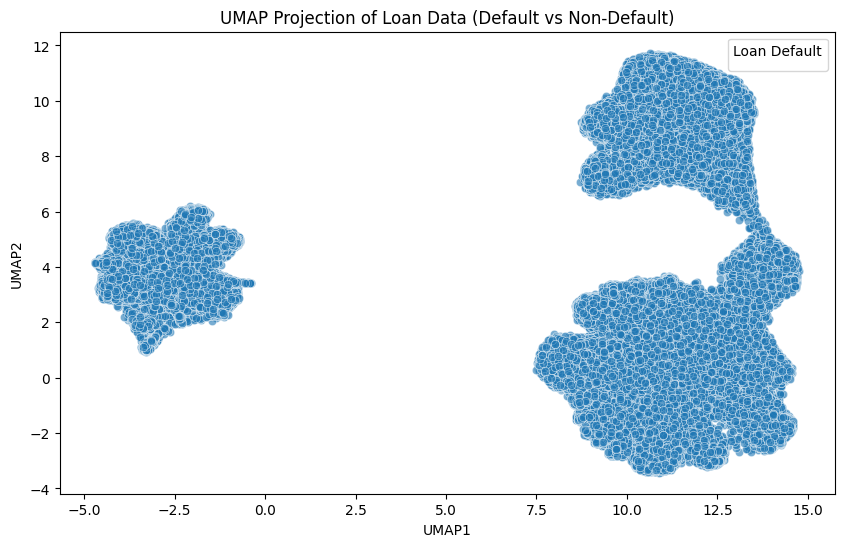

In [ ]:
umap = UMAP(n_neighbors=30, n_components=2, metric='cosine', random_state=1)
umap_2d_df = umap.fit_transform(df_num)
df_vis = pd.DataFrame(umap_2d_df, columns=['UMAP1', 'UMAP2'])
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_vis,
    x='UMAP1',
    y='UMAP2',
    alpha=0.6
)
plt.title('UMAP Projection of Loan Data (Default vs Non-Default)')
plt.legend(title='Loan Default')
plt.show()

### For Numerical

In [ ]:
reducer = UMAP(n_neighbors=30, 
               n_components=2, 
               metric='cosine', 
               random_state=1)

reducer.fit(df_num)

/Users/jacobwarchola/Desktop/loan_project/venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/jacobwarchola/Desktop/loan_project/venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP(angular_rp_forest=True, metric='cosine', n_jobs=1, n_neighbors=30, random_state=1, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [ ]:
embedding = reducer.transform(df_num)

# Verify that the result of calling transform is
# idenitical to accessing the embedding_ attribute
assert(np.all(embedding == reducer.embedding_))
embedding.shape

/Users/jacobwarchola/Desktop/loan_project/venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


(307507, 2)

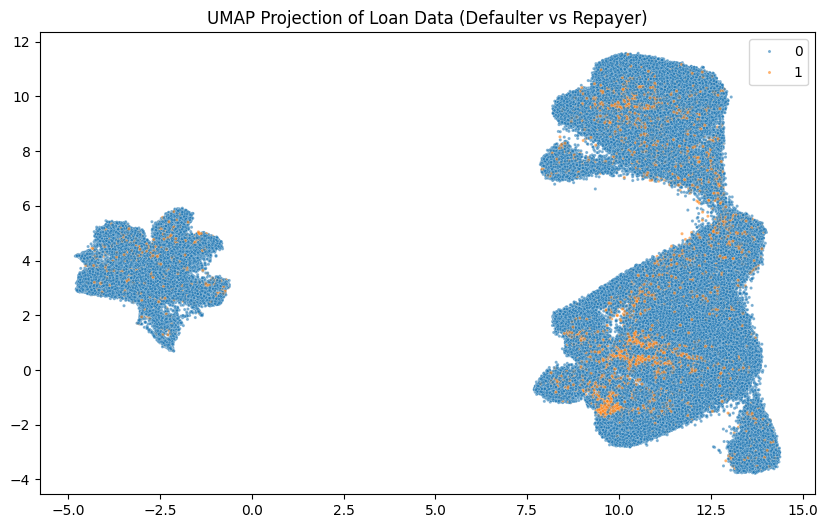

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=embedding[:, 0],
    y=embedding[:, 1],
    alpha=0.6,
    hue=df_num['remainder__TARGET'],  
    s=5
)
plt.title('UMAP Projection of Loan Data (Defaulter vs Repayer)')
plt.legend()
plt.show()

### For Numerical and Categorical

In [ ]:
reducer = UMAP(n_neighbors=30, 
               n_components=2, 
               metric='cosine', 
               random_state=1)

reducer.fit(df_cleaned)

/Users/jacobwarchola/Desktop/loan_project/venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/jacobwarchola/Desktop/loan_project/venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP(angular_rp_forest=True, metric='cosine', n_jobs=1, n_neighbors=30, random_state=1, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [ ]:
embedding = reducer.transform(df_cleaned)

# Verify that the result of calling transform is
# idenitical to accessing the embedding_ attribute
assert(np.all(embedding == reducer.embedding_))
embedding.shape

/Users/jacobwarchola/Desktop/loan_project/venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


(307507, 2)

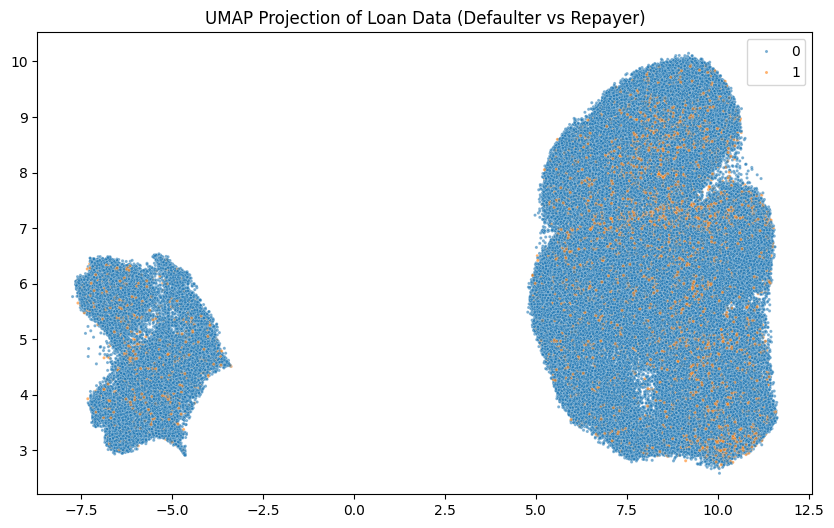

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=embedding[:, 0],
    y=embedding[:, 1],
    alpha=0.6,
    hue=df_cleaned['remainder__remainder__TARGET'],  
    s=5
)
plt.title('UMAP Projection of Loan Data (Defaulter vs Repayer)')
plt.legend()
plt.show()

In [ ]:
db = DBSCAN(
    eps=0.3,
    min_samples=10,
    metric = 'euclidean'
    ).fit(df_num)
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

NameError: name 'DBSCAN' is not defined

In [ ]:
pca = PCA(n_components=0.95)
numpy_arr = pca.fit_transform(df_num)
df_reduced = pd.DataFrame(data=numpy_arr.flatten())